## Importing the necessary packages

In [1]:
import cv2
import numpy as np
import glob
from tqdm import tqdm
import sys
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Loading and preprocessing images from the DeepGlobe dataset

In [3]:
# Download dataset if not already present.
#!curl -L -o deepglobe-land-cover-classification-dataset.zip https://www.kaggle.com/api/v1/datasets/download/balraj98/deepglobe-land-cover-classification-dataset
#!unzip deepglobe-land-cover-classification-dataset.zip

In [4]:
path = os.path.join("/kaggle", "input", "deepglobe-land-cover-classification-dataset")

img_shape = (2448, 2448, 3) # Original image shape
input_shape = (512, 512, 3) # Model image shape
out_shape = (512, 512, 1) # Output mask shape

In [5]:
def preprocess_img(img, shape, is_mask = False):
    # Images are converted from BGR to RGB.
    # Then, their resolution is lowered to accomodate our memory constraints.

    image = cv2.resize(cv2.imread(img), shape, interpolation = cv2.INTER_LINEAR if not is_mask else cv2.INTER_NEAREST)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
    
def preprocess_mask(img, shape):
    # Transforming masks from 3 channel to a singular class channel with values from 0 to 6.
    mask = np.array(np.round(preprocess_img(img, shape, is_mask = True) / 255.0), dtype = np.uint8)
    mask_refined = 4 * mask[:,:,0] + 2 * mask[:,:,1] + mask[:,:,2]
    mask_refined = mask_refined * (mask_refined != 7) + 4 * (mask_refined == 7)
    return mask_refined

def get_dataset(mask_dirs):
    # Each mask file is matched to its corresponding satellite image.  
    sat_dirs = [d.replace("_mask.png", "_sat.jpg") for d in mask_dirs]
    
    X = tf.convert_to_tensor([preprocess_img(file, input_shape[:2]) for file in sat_dirs], dtype=tf.uint8)
    y = tf.convert_to_tensor([preprocess_mask(file, out_shape[:2]) for file in mask_dirs], dtype=tf.uint8)
    
    return X, y

In [6]:
# Loading the labeled data.
train_path = os.path.join(path, "train")
mask_dirs = glob.glob(os.path.join(train_path,"*_mask.png"))

n = len(mask_dirs)
train_split = 0.8 # TODO: Increase to 0.9 for final training.
n_train = int(n * train_split)
n_val = n - n_train

X_train, y_train = get_dataset(mask_dirs[:n_train])
print(f"Loaded {n_train} training images.")
X_val, y_val = get_dataset(mask_dirs[n_train:n])
print(f"Loaded {n_val} validation images.")

#X_val, y_val = get_dataset(os.path.join(path, "valid"))
#X_test, y_test = get_dataset(os.path.join(path, "test"))

Loaded 642 training images.
Loaded 161 validation images.


## Model definition

In [7]:
# 2 consecutive padded convolutions with ReLU activations as outlined in the U-Net paper.
# Is the basis for both in the Encoder and the Decoder.

class ConvBlock(tf.keras.Layer):
    def __init__(self, n_filters, filter_size):
        super().__init__()
        self.cn1 = tfl.Conv2D(n_filters, filter_size,
                            padding = "same")
        self.relu1 = tfl.ReLU()
        self.cn2 = tfl.Conv2D(n_filters, filter_size,
                            padding = "same")
        self.relu2 = tfl.ReLU()
        
    def call(self, x):
        x = self.relu1(self.cn1(x))
        x = self.relu2(self.cn2(x))
        return x
        

In [8]:
class UNetConv(ConvBlock):
    def __init__(self, n_filters, filter_size, pool_stride):
        super().__init__(n_filters, filter_size)
        # Pooling layer to reduce image resolution.
        self.pool = tfl.MaxPooling2D(pool_stride)

    def call(self, x):
        x = super().call(x)
        return x, self.pool(x)
        
    
class UNetTConv(ConvBlock):
    def __init__(self, filters, filter_size, tfilters, tfilter_size):
        super().__init__(filters, filter_size)
        # ConvTranspose to restore image resolution, should us the same filter size as the pool stride.
        self.dcn = tfl.Conv2DTranspose(tfilters, tfilter_size, tfilter_size, padding = "same")

    def call(self, x):
        return self.dcn(super().call(x))

In [9]:
n_blocks = 4 # Number of encoder and decoder block.
log_conv_filters = 4 # Number of filters in the first convolutional layer is 2^log_conv_filters.
# Increased by a factor of 2 for each subsequent layer. Inverse order for the decoder.
n_classes = 7 # Number of possible classes for each output pixel.
filter_size = 3 # Convolution filter size: 3*3
tfilter_size = 2 # Transposed convolution filter size: 2*2, should revert the pooling operation.
dropout = 0.0

In [10]:
class UNET(tf.keras.Model):
    
    def __init__(self, blocks):
        super().__init__()
        self.scale = tfl.Rescaling(1.0 / 255.0)
        self.convs = [UNetConv(int(2**(log_conv_filters+i)), filter_size, 2) for i in range(blocks)] # encoder
        self.dropouts = [tfl.Dropout(dropout) for _ in range(blocks)] # Dropout is used at each decoder step.
        self.tconvs = [UNetTConv(int(2**(log_conv_filters + blocks -i)), filter_size,\
                int(2**(log_conv_filters + blocks -i)), tfilter_size) for i in range(blocks)] # decoder
        
        self.convf = ConvBlock(int(2**(log_conv_filters)), filter_size) # Final convolution before classification.
        self.conv1x1 =  tfl.Conv2D(n_classes, 1, padding = "same") # Convolution across the channels to get 1 probability per class.
        # self.softmax = tfl.Softmax(axis = -1)
    
    def call(self, x, training = False):
        x = self.scale(x)
        xs = []
        for conv in self.convs:
            # storing the unpooled feature maps for skip connections.
            skip, x = conv(x)
            xs.append(skip)

        skip = None
        for tconv, dropout in zip(self.tconvs, self.dropouts):
            x = x if skip is None else tf.concat([skip, x], axis = -1)
            x = tconv(dropout(x, training = training))
            skip = xs.pop()
            
        x = self.convf(tf.concat([skip, x], axis = -1))
        x = self.conv1x1(x)
        
        return x

In [11]:
inputs = tf.keras.Input(input_shape)
model = UNET(n_blocks)
model(inputs)
model.summary()

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_conv (UNetConv)           │ ?                      │         2,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_conv_1 (UNetConv)         │ ?                      │        13,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_conv_2 (UNetConv)         │ ?                      │        55,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_conv_3 (UNetConv)         │ ?                      │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_t_conv (UNetTConv)        │ ?                      │     1,147,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_t_conv_1 (UNetTConv)      │ ?                      │       655,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_t_conv_2 (UNetTConv)      │ ?                      │       164,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_t_conv_3 (UNetTConv)      │ ?                      │        41,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block (ConvBlock)          │ ?                      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ ?                      │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,311,367 (8.82 MB)

 Trainable params: 2,311,367 (8.82 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [12]:
epsilon = 1e-9 # To avoid log(0).

freqs = np.zeros((n_classes,))
for c in range(n_classes):
    freqs[c] = np.mean(y_train.numpy() == c)

unknown_class = 0
beta = 0.1
class_weights = (1 - beta) / (1 - beta**freqs)
class_weights[unknown_class] = 0.0

def SparseCategoricalCrossentropy(y_true, y_pred):
    valid_mask = tf.math.not_equal(y_true, unknown_class)
    # y_true = (batch_size, 1) -> one hot (batch_size, n_classes) -> frequency coefficient (each class would have its own weight instead of 1)
    y_true = tf.one_hot(tf.reshape(y_true,(-1,)), n_classes) * class_weights # removing the unknown class
     # (B, n_classes) * (n_classes,). Should broadcast.
    # y_pred = (batch_size, n_classes)
    y_pred = tf.reshape(y_pred, (-1, n_classes))
    y_pred = y_pred - tf.reduce_max(y_pred, axis = -1, keepdims = True)
    log_prob = - tf.math.log(tf.nn.softmax(y_pred, axis = -1) + epsilon)

    return tf.reduce_sum(y_true * log_prob) / tf.reduce_sum(tf.cast(valid_mask, tf.float32))

In [13]:
# F1 per class is used as the evaluation metric.
f1 = tf.keras.metrics.F1Score(average = "weighted")

def f1_score_images(y_true, y_pred):
    # Includes empty class.
    f1.reset_state()
    y_true_flat = tf.one_hot(tf.reshape(y_true,(-1,)), n_classes)
    y_pred_flat = tf.one_hot(tf.reshape(tf.argmax(y_pred, axis = -1), (-1,)), n_classes)
    return f1(y_true_flat, y_pred_flat)

In [14]:
def IoU(y_true, y_pred):
    # Includes empty class. Weighted by class frequency.
    y_true = tf.reshape(y_true, (-1,))
    y_pred = tf.reshape(tf.argmax(y_pred, axis = -1), (-1,))

    ious = []
    for c in range(n_classes):
        y_true_c = tf.cast(tf.equal(y_true, c), tf.float32)
        y_pred_c = tf.cast(tf.equal(y_pred, c), tf.float32)

        intersection = tf.reduce_sum(y_true_c * y_pred_c)
        union = tf.reduce_sum(y_true_c) + tf.reduce_sum(y_pred_c) - intersection + epsilon

        ious.append(intersection / union)

    return tf.reduce_sum(freqs * tf.stack(ious))

In [15]:
lr = 1e-3
loss_fn = SparseCategoricalCrossentropy #tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, ignore_class = 0) #SparseCategoricalCrossentropy
optimizer = tf.keras.optimizers.Adam(lr)
model.compile(loss = loss_fn, optimizer = optimizer, metrics = [f1_score_images])

In [16]:
def augment_image(X, y, t = 0.2, r = 20.0):
    # Translation.
    dy = tf.random.uniform([], -t, t) * input_shape[0]
    dx = tf.random.uniform([], -t, t) * input_shape[1]

    translation_matrix = tf.convert_to_tensor([[1, 0, -dx],
                                            [0, 1, -dy],
                                            [0, 0, 1]], dtype=tf.float32) 

    # Rotation.
    rotation_angle = tf.random.uniform([], -r, r) * np.pi / 180.0
    cos = tf.cos(rotation_angle)
    sin = tf.sin(rotation_angle)
    rotation_matrix = tf.convert_to_tensor([[cos, -sin, 0],
                                        [sin, cos, 0],
                                        [0, 0, 1]], dtype=tf.float32)

    # First 6 entries of 3x3 matrix are the affine parameters, 7th and 8th should just be 0.
    transform_matrix = tf.cast(rotation_matrix @ translation_matrix, tf.float32)
    transform_params = tf.reshape(transform_matrix, (1, 9))[:, :8]

    X = tf.keras.ops.image.affine_transform(
    X,
    transform_params,
    interpolation='bilinear',
    fill_mode='nearest',
    data_format='channels_last'
    )

    y  = tf.keras.ops.image.affine_transform(
    tf.expand_dims(y, axis = -1),
    transform_params,
    interpolation='nearest',
    fill_mode='nearest',
    data_format='channels_last'
    )

    return X, tf.squeeze(y, axis = -1)

In [17]:
t = 0.2 # translation factor
r = 0.0 # maximum absolute rotation angle

@tf.function
def train_step(X, y):
    X, y = augment_image(X, y, t, r)

    with tf.GradientTape() as tape:
        preds = model(X, training = True)
        loss = loss_fn(y, preds)
    f1_score = f1_score_images(y, preds)
    iou = IoU(y, preds)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return loss, f1_score, iou

In [18]:
@tf.function
def val_step(X, y):
    preds = model(X, training = False)
    loss = loss_fn(y, preds)
    f1_score = f1_score_images(y, preds)
    iou = IoU(y, preds)
    return loss, f1_score, iou

In [19]:
history = {}
batch_size = 1
EPOCHS = 200

# tqdm logs to stderr by default.
stderr = sys.stderr
sys.stderr = sys.stdout

In [20]:
for epoch in range(EPOCHS):
    # Training loop
    train_loss, train_f1, train_iou = 0, 0, 0
    
    for i in tqdm(range(0, X_train.shape[0], batch_size)):
        X_batch = X_train[i: i + batch_size]
        y_batch = y_train[i: i + batch_size]
        loss, f1_score, iou = train_step(X_batch, y_batch)
        train_loss += loss * X_batch.shape[0]
        train_f1 += f1_score * X_batch.shape[0]
        train_iou += iou * X_batch.shape[0]

    train_loss /= n_train
    train_f1 /= n_train
    train_iou /= n_train

    history["loss"] = history.get("loss", []) + [train_loss]
    history["f1"] = history.get("f1", []) + [train_f1]

    val_loss, val_f1, val_iou = 0, 0, 0

    for j in range(0, X_val.shape[0], batch_size):
        X_batch_val = X_val[j: j + batch_size]
        y_batch_val = y_val[j: j + batch_size]
        loss, f1_score, iou = val_step(X_batch_val, y_batch_val)
        val_loss += loss * X_batch_val.shape[0]
        val_f1 += f1_score * X_batch_val.shape[0]
        val_iou += iou * X_batch_val.shape[0]

    val_loss /= n_val
    val_f1 /= n_val
    val_iou /= n_val

    history["val_loss"] = history.get("val_loss", []) + [val_loss]
    history["val_f1"] = history.get("val_f1", []) + [val_f1]

    print(f"Epoch {epoch + 1} / {EPOCHS} loss: {train_loss:0.4f}, F1: {train_f1:0.4f}, IoU: {train_iou:0.4f} val_loss: {val_loss:0.4f}, val_f1: {val_f1:0.4f}, val IoU: {val_iou:0.4f}")

100%|██████████| 642/642 [00:26<00:00, 23.94it/s]
Epoch 1 / 200 loss: 5.1590, F1: 0.4489, IoU: 0.2869 val_loss: 5.2354, val_f1: 0.4748, val IoU: 0.2469
100%|██████████| 642/642 [00:18<00:00, 35.61it/s]
Epoch 2 / 200 loss: 5.0443, F1: 0.4767, IoU: 0.3015 val_loss: 5.2429, val_f1: 0.1270, val IoU: 0.0227
100%|██████████| 642/642 [00:18<00:00, 35.64it/s]
Epoch 3 / 200 loss: 4.8480, F1: 0.4742, IoU: 0.2819 val_loss: 5.0658, val_f1: 0.1439, val IoU: 0.0279
100%|██████████| 642/642 [00:18<00:00, 35.60it/s]
Epoch 4 / 200 loss: 4.7338, F1: 0.4768, IoU: 0.2576 val_loss: 4.9214, val_f1: 0.1945, val IoU: 0.0475
100%|██████████| 642/642 [00:18<00:00, 35.61it/s]
Epoch 5 / 200 loss: 4.6053, F1: 0.4731, IoU: 0.2373 val_loss: 4.5539, val_f1: 0.4516, val IoU: 0.2061
100%|██████████| 642/642 [00:18<00:00, 35.61it/s]
Epoch 6 / 200 loss: 4.4069, F1: 0.5094, IoU: 0.2526 val_loss: 4.5836, val_f1: 0.4071, val IoU: 0.1790
100%|██████████| 642/642 [00:18<00:00, 35.62it/s]
Epoch 7 / 200 loss: 4.3059, F1: 0.5028

In [21]:
# We reconfigure stderr to default
sys.stderr = stderr

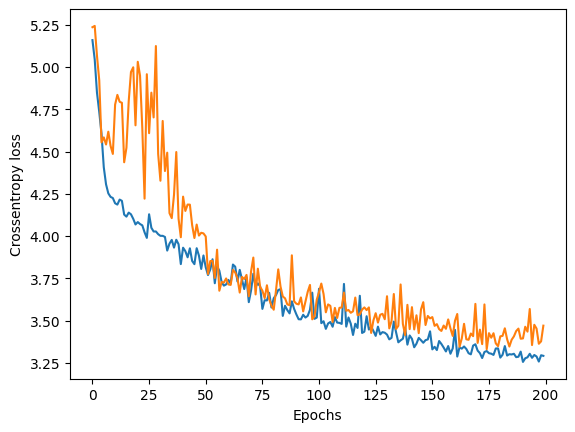

In [22]:
plt.plot(history["loss"], label = "Training loss")
plt.plot(history["val_loss"], label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Crossentropy loss")
plt.show()

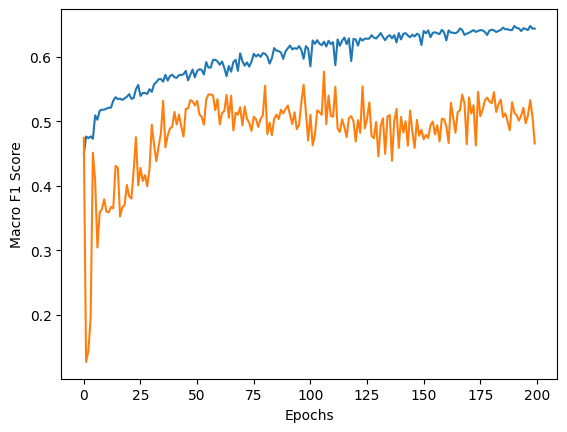

In [23]:
plt.plot(history["f1"], label = "Training F1")
plt.plot(history["val_f1"], label = "Validation F1")
plt.xlabel("Epochs")
plt.ylabel("Macro F1 Score")
plt.show()

## Evaluation

In [24]:
def predict_mask(X_target):
    if len(X_target.shape) == 3:
        # Add batch dimension
        X_target = tf.reshape(X_target, (1,) + X_target.shape)
    
    y_pred = tf.argmax(model(X_target), axis = -1)[0]
    
    return y_pred

In [25]:
def to_img(y):
    """Convert class mask back to image for visualization."""
    out = np.zeros(y.shape[:2] + (3,))
    
    out[:, :, 0] = (y // 4)
    out[:, :, 1] = ((y % 4) // 2)
    out[:, :, 2] = (y % 2)

    return out

In [26]:
def confusion_matrix_show(cm):
    class_labels = list(range(n_classes))
    sns.heatmap(cm, 
                annot=True,
                fmt='g', 
                cmap='Blues',
                xticklabels=class_labels, 
                yticklabels=class_labels)
    
    plt.ylabel('Actual', fontsize=13)
    plt.title('Confusion Matrix', fontsize=17, pad=20)
    plt.gca().xaxis.set_label_position('top')
    plt.xlabel('Prediction', fontsize=13)
    plt.gca().xaxis.tick_top()
    
    plt.gca().figure.subplots_adjust(bottom=0.2)
    plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
    plt.show()

In [27]:
def Visualize_output(X_target, y_target):
    y_pred = predict_mask(X_target)
    img_pred = to_img(y_pred)
    img_real = to_img(y_target)

    y_target_flat = tf.reshape(y_target,-1)
    y_pred_flat = tf.reshape(y_pred, -1)

    cm = confusion_matrix(y_target_flat, y_pred_flat, labels = np.arange(n_classes))
    confusion_matrix_show(cm)
    f1.reset_state()
    print(f"F1 Score: {f1(tf.one_hot(y_target_flat, n_classes), tf.one_hot(y_pred_flat, n_classes))}")
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot first image
    axes[0].imshow(img_pred, interpolation = 'nearest')
    axes[0].axis('off')
    axes[0].set_title("Predicted mask:")
    
    # Plot second image
    axes[1].imshow(img_real, interpolation = 'nearest')
    axes[1].axis('off')
    axes[1].set_title("Real mask:")
    
    # Display the images
    plt.tight_layout()
    plt.show()

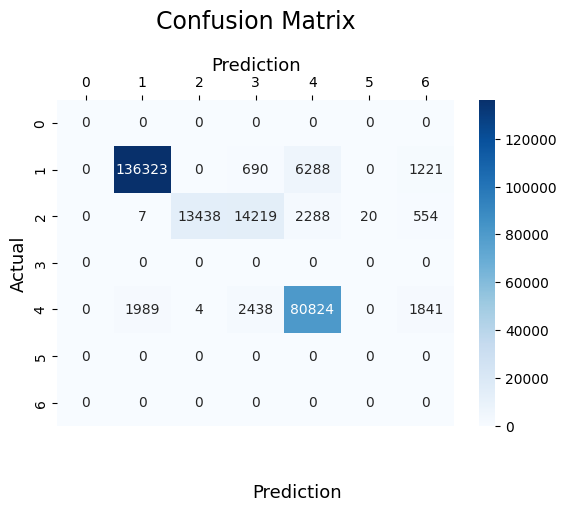

F1 Score: 0.9069100022315979


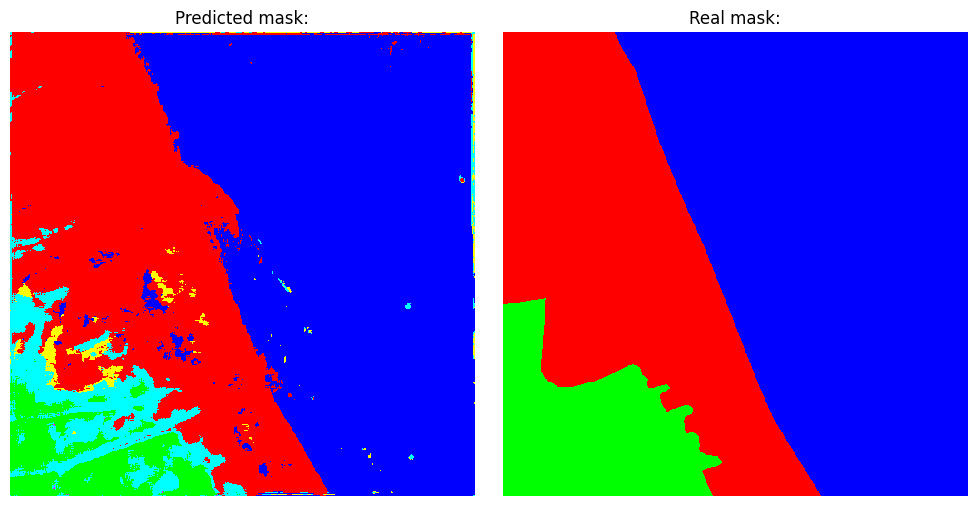

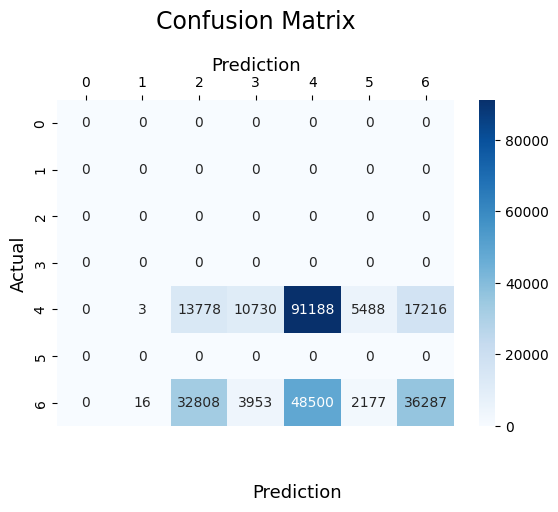

F1 Score: 0.5395255088806152


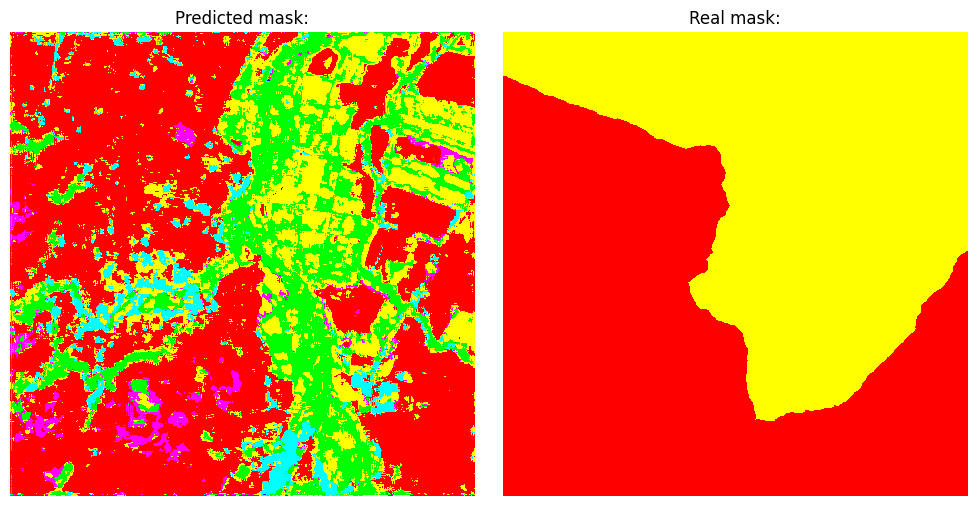

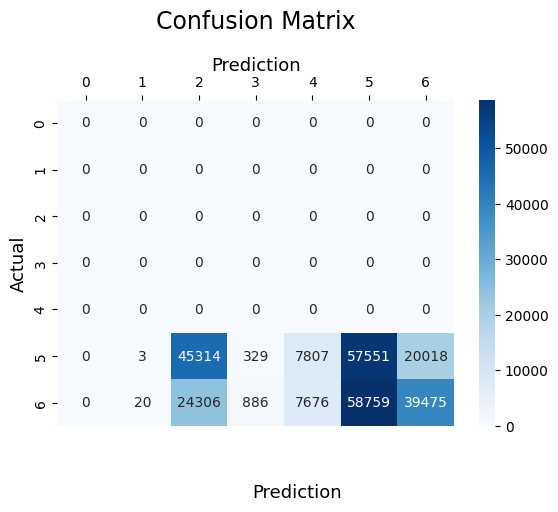

F1 Score: 0.4397702217102051


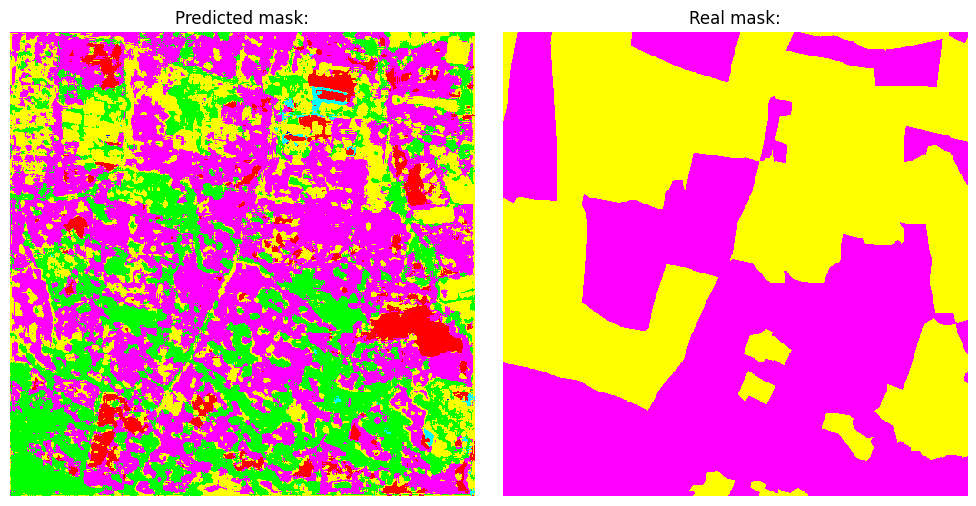

In [28]:
random_indices = np.random.randint(0, n_val, 3)
for i in random_indices:
    Visualize_output(X_val[i], y_val[i])